In [1]:
# imports
import astropy as ap
from astropy.io import ascii
from astropy.io import fits
from astropy import units as u
import astropy.table as at
from astropy.time import Time
import astropy.coordinates as coords 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import lightkurve as lk
from fpdf import FPDF
import thejoker as tj
from astropy.timeseries import LombScargle

In [2]:
def getStarData(apogeeFileName,tessFileName,binariesFile):
  # APOGEE Visits Data
  apogeeVisits=at.Table.read(apogeeFileName) # import file
  # Binary Catalog
  binaries=at.QTable.read(binariesFile) # import file
  # Tess Data
  tessData=at.QTable.read(tessFileName) # import file
  tessData=tessData[tessData['separation']<2.*u.arcsec] # separation Filter
  # join tables
  sources=at.join(binaries,tessData,keys='APOGEE_ID')
  sources=sources[0:10] # Limits stars for testing .py version will run all stars
  return apogeeVisits, sources


In [3]:
def getJokerRVData(allVisits,sources):
  data=[]
  for row in sources:
    visits=allVisits[allVisits['APOGEE_ID']==row['APOGEE_ID']]
    datum=tj.RVData(Time(visits['JD'],format='jd'),
                    rv=visits['VHELIO']*u.km/u.s,
                    rv_err=visits['VRELERR']*u.km/u.s)
    data.append(datum)
  return data

In [4]:
def getLightCurveData(sources):
  ticList=[]
  timeList=[]
  fluxList=[]
  fluxErrList=[]
  for tic in sources['TICID']:
    ticStr='TIC'+str(tic)
    ticList.append(ticStr)
    print(ticStr)
    try:
      lcCollection=lk.search_lightcurve(target=ticStr,mission='TESS').download_all()
      lcStitch=lcCollection.stitch().remove_nans().remove_outliers()
      time=lcStitch.time.value
      flux=1e3*(lcStitch.flux-1)
      fluxErr=1e3*(lcStitch.flux_err)
      time=np.ascontiguousarray(time)
      flux=np.ascontiguousarray(flux,dtype=np.float64)
      timeList.append(time)
      fluxList.append(flux)
      fluxErrList.append(fluxErr)
    except: #still having that weird bug with lightkurve hopefully this works as a temporary fix
      print('Probably MergeConflictError and/or TableMergeError')
      timeList.append([])
      fluxList.append([])
      fluxErrList.append([])
      pass
    lcDataTable=at.QTable([ticList,timeList,fluxList,fluxErrList],names=('TICID',
                                                                       'Time',
                                                                       'Flux',
                                                                       'Flux_err'))
  return lcDataTable

In [5]:
def getLsPeriodogram(sources):
    freqList=[]
    powList=[]
    lcData=getLightCurveData(sources)
    for i in range(len(sources['MAP_P'])):
        period=int(sources[i]['MAP_P']/u.d)
        timeViaLC=lcData[i]['Time']
        fluxViaLC=lcData[i]['Flux']
        freq,pow=LombScargle(timeViaLC,fluxViaLC).autopower(minimum_frequency=(.1/period),maximum_frequency=(10./period))
        freqList.append(freq)
        powList.append(pow)
    periodogramDataTable=at.QTable([freqList,powList],names=('Frequency','Power'))
    return periodogramDataTable
    


In [6]:
def getPlots(sources,jData,periodogram,joker,prior_sample):
  pdf=FPDF(unit='in',format=[8.5,11])
  for i in range(len(sources['APOGEE_ID'])):
    # Titles
    supTitle='APOGEE ID: '+str(sources[i]['APOGEE_ID']+' | TIC ID: TIC'+str(sources[i]['TICID']))
    plot1Title='Eccentricity vs Period'
    plot2Title='Lomb Scargle Periodogram'
    # Figure Creation
    fig,(ax1,ax2)=plt.subplots(nrows=2,ncols=1,figsize=(20,10),facecolor='w')
    fig.suptitle(supTitle)
    # plot 1
    sample=joker.rejection_sample(jData[i],prior_sample)
    ax1.plot(sample['P'],sample['e'],'k.')
    ax1.set_xlabel('Period (d)')
    ax1.set_ylabel('Eccentricity')
    ax1.set_title(plot1Title)
    # Plot 2
    freq=periodogram[i]['Frequency']
    pow=periodogram[i]['Power']
    ax2.plot(freq,pow)
    ax2.set_xlabel('Frequency (1/d)')
    ax2.set_ylabel('Power')
    ax2.set_title(plot2Title)

    # save figure
    pngPath='PlotsForJupyter/NotebookPeriodogram_EccenPeriod_'+str(sources[i]['APOGEE_ID'])+'.png'
    fig.savefig(pngPath,dpi=150)
    pdf.add_page()
    pdf.image(pngPath,w=8,h=9.6)
    print(supTitle+'DONE')
    pdf.output('PlotsForJupyter/NotebookAll_Periodogram_EccenPeriod_Plots.pdf','F')
  print('PLOTS SAVED AS PDF')

In [7]:
apogeeFile='DataForJupyter/allVisit-r12-l33.fits'
tessFile='DataForJupyter/allStarLite-r12-l33-tess_2min-max_20arcsec-xm.fits'
binaryMetadataFile='DataForJupyter/allStarLite-metadata.fits'
apogeeData,sourceData=getStarData(apogeeFile,tessFile,binaryMetadataFile)
jokerRVData=getJokerRVData(apogeeData,sourceData)
lsPeriodogramData=getLsPeriodogram(sourceData)
prior=tj.JokerPrior.default(P_min=0.2*u.day,P_max=25*u.day,sigma_K0=300*u.km/u.s,sigma_v=100*u.km/u.s)
joker=tj.TheJoker(prior)
priorSample=prior.sample(100_00)

TIC388602672


/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:214: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_flux', 'sap_bkg', 'sap_bkg_err'}
  LightkurveWarning,


TIC257487686


/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subok=True, ndmin=ndmin)


TIC257501815


/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subok=True, ndmin=ndmin)


TIC257501838


/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subok=True, ndmin=ndmin)


TIC293219556


/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subok=True, ndmin=ndmin)


TIC300943035


/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subok=True, ndmin=ndmin)


TIC300943055


/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subok=True, ndmin=ndmin)


TIC293256256


/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subok=True, ndmin=ndmin)


TIC461356882


/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:214: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_flux', 'sap_bkg', 'sap_bkg_err'}
  LightkurveWarning,
/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subok=True, ndmin=ndmin)


TIC266968386


/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/lightkurve/collections.py:214: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_flux', 'sap_bkg', 'sap_bkg_err'}
  LightkurveWarning,
/Users/jonahgoldfine/opt/anaconda3/lib/python3.7/site-packages/astropy/units/quantity.py:378: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subok=True, ndmin=ndmin)


APOGEE ID: 2M00014989+8003031 | TIC ID: TIC388602672DONE
APOGEE ID: 2M00015793+0007429 | TIC ID: TIC257487686DONE
APOGEE ID: 2M00020618+0030136 | TIC ID: TIC257501815DONE
APOGEE ID: 2M00020648+0024553 | TIC ID: TIC257501838DONE
APOGEE ID: 2M00055366+0032349 | TIC ID: TIC293219556DONE
APOGEE ID: 2M00065352+0005222 | TIC ID: TIC300943035DONE
APOGEE ID: 2M00065839-0003437 | TIC ID: TIC300943055DONE
APOGEE ID: 2M00070793+0102473 | TIC ID: TIC293256256DONE
APOGEE ID: 2M00100420+6728110 | TIC ID: TIC461356882DONE
APOGEE ID: 2M00113731-7216318 | TIC ID: TIC266968386DONE
PLOTS SAVED AS PDF


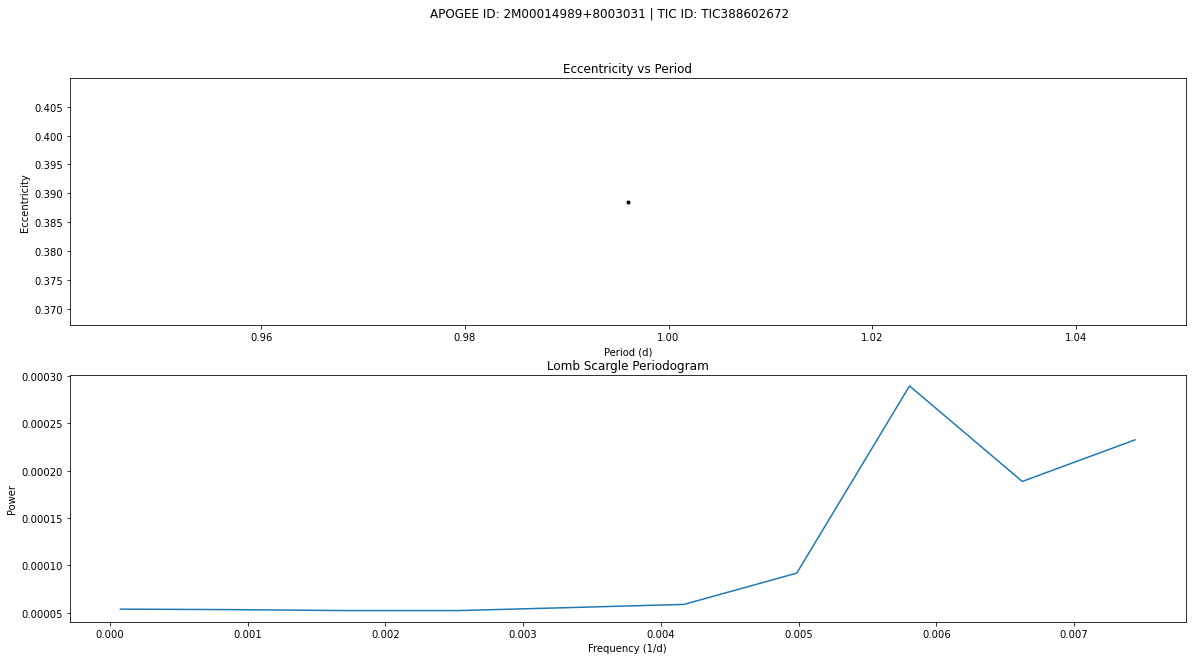

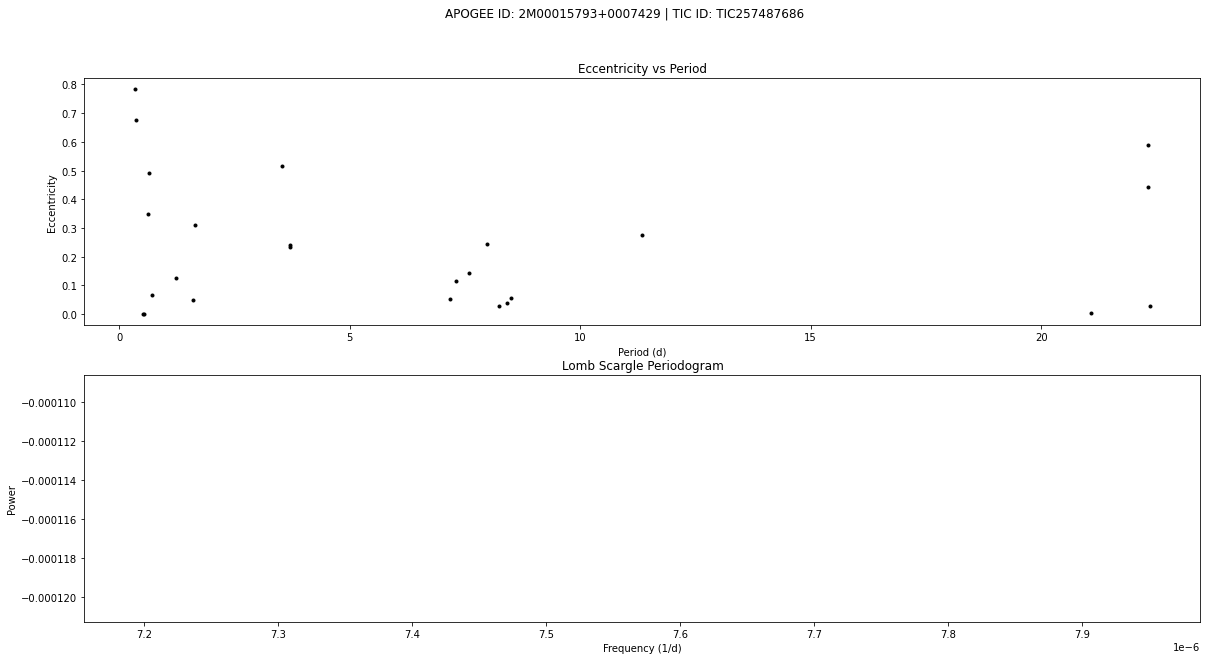

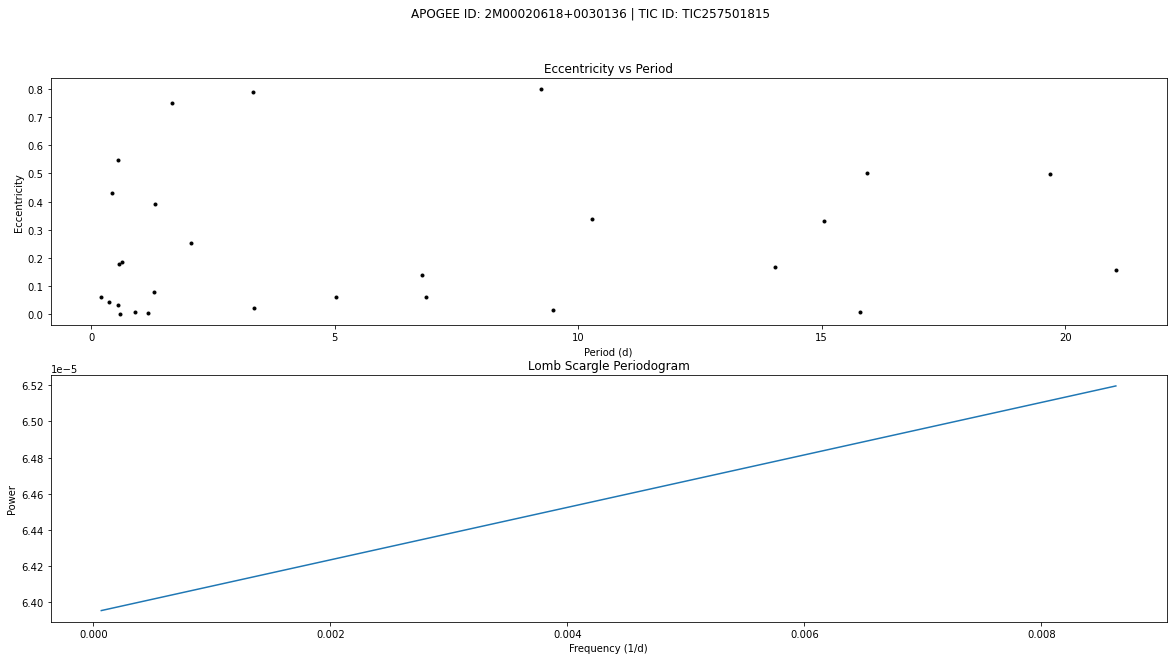

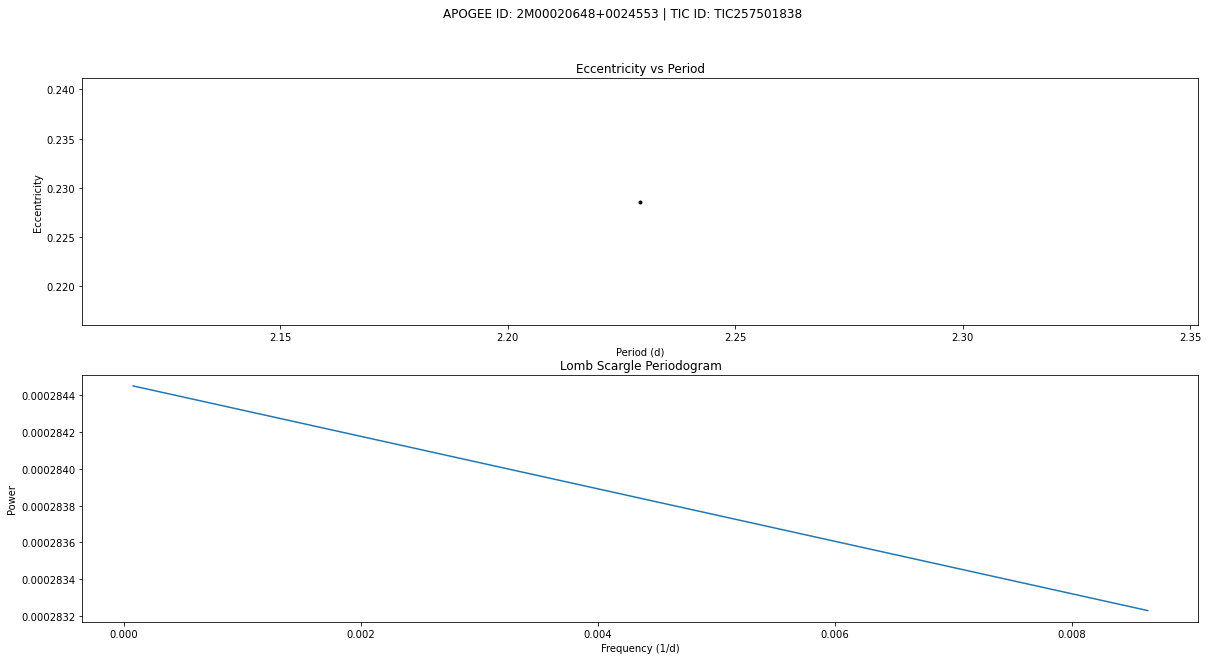

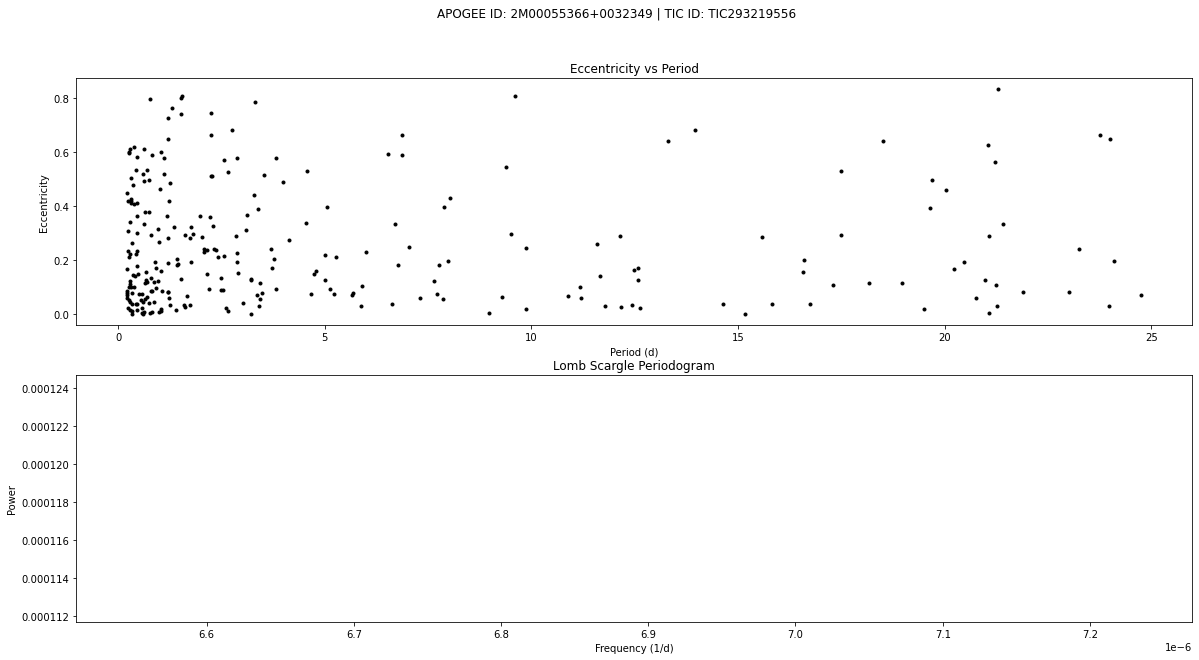

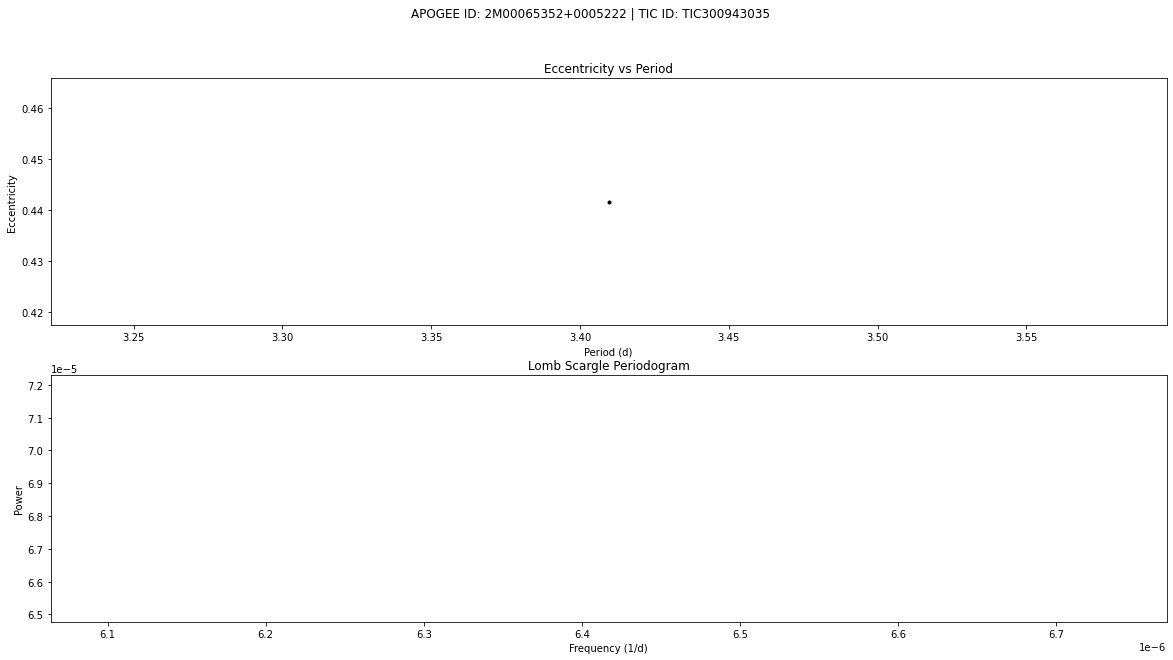

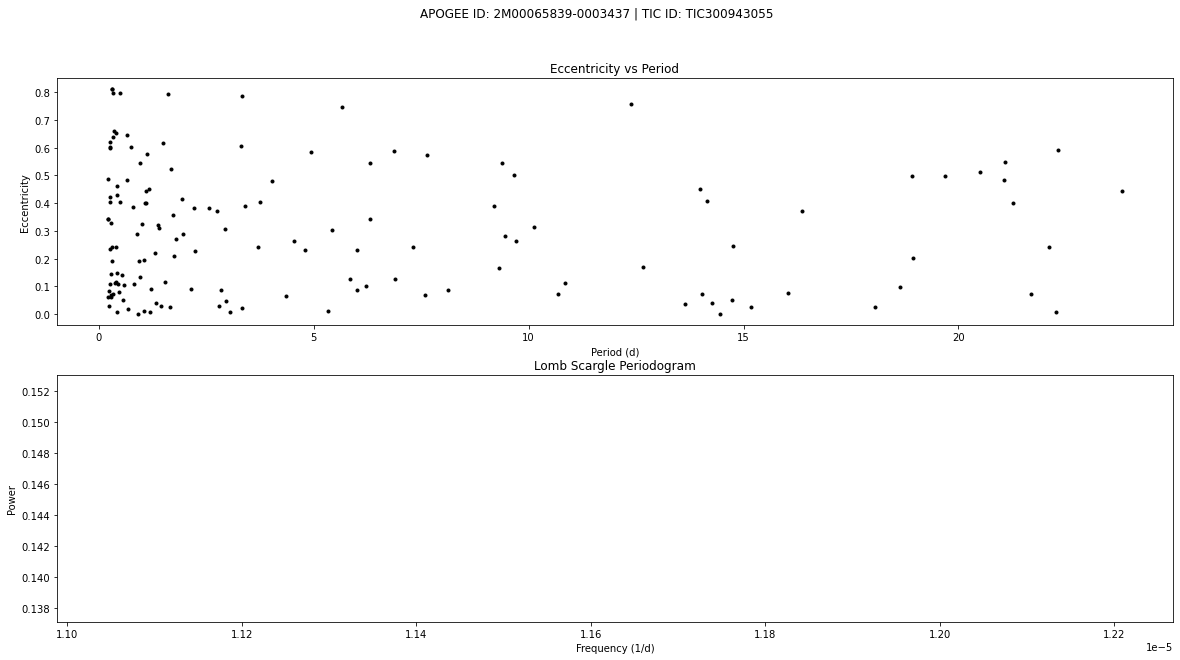

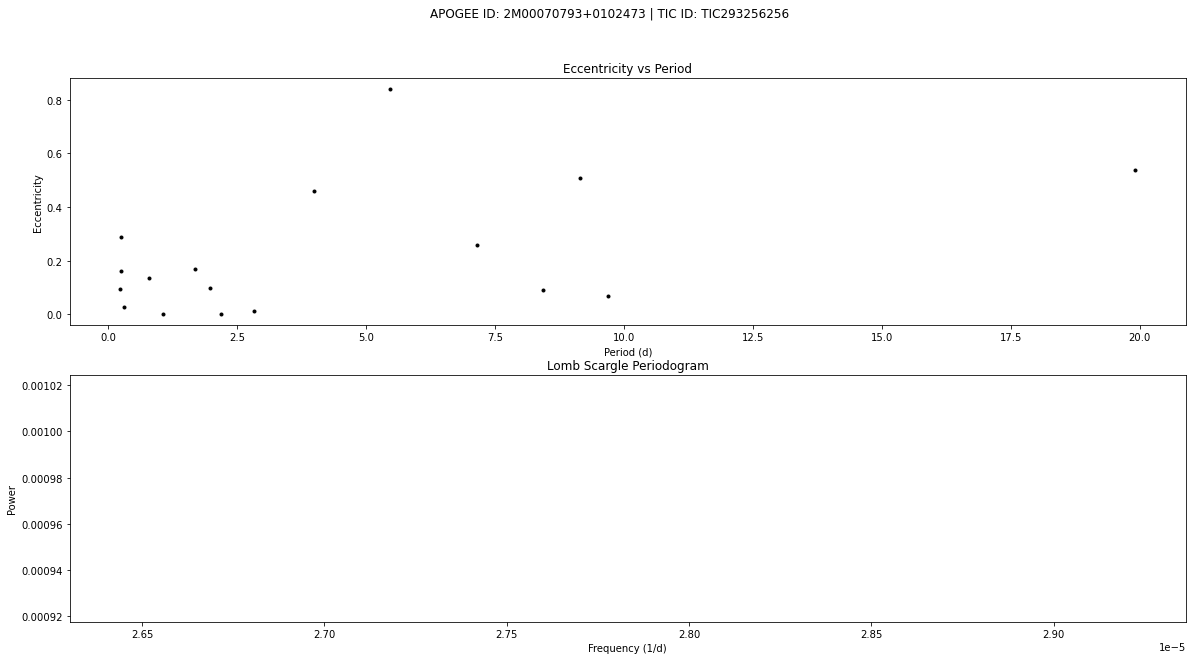

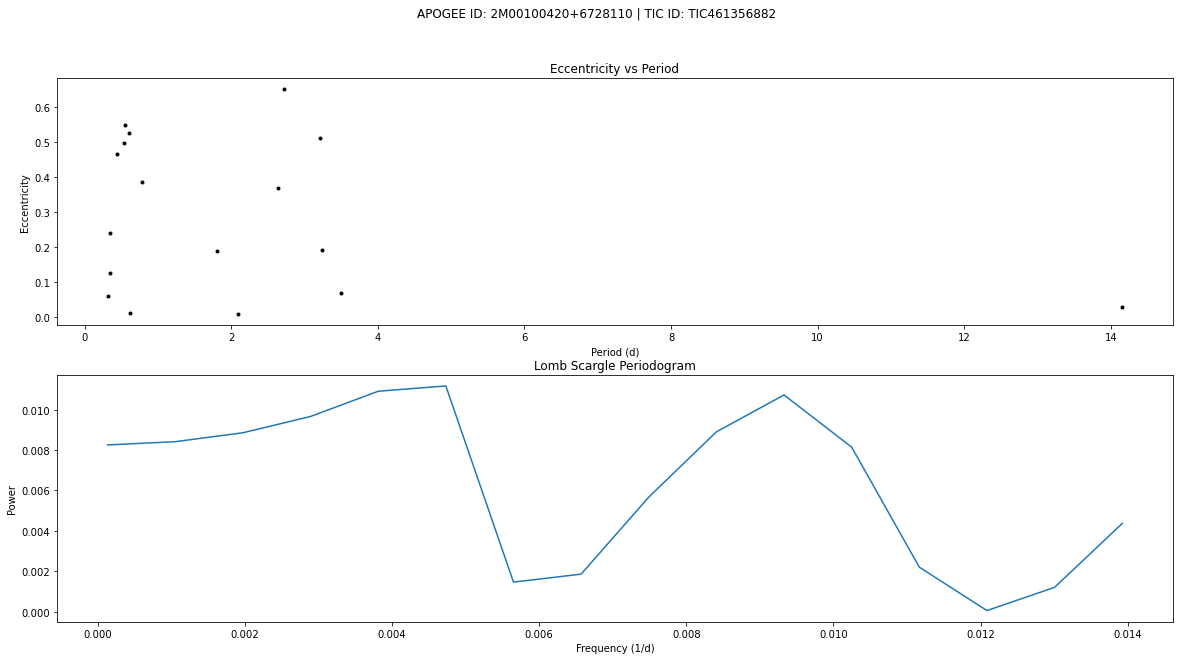

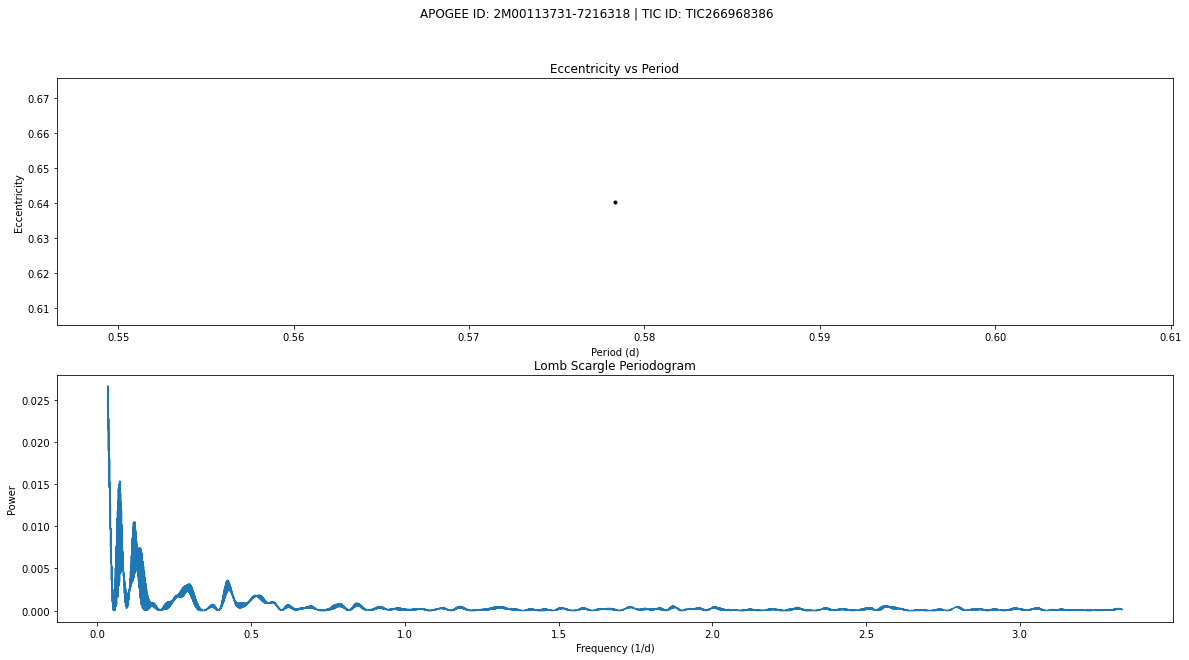

In [8]:
getPlots(sourceData,jokerRVData,lsPeriodogramData,joker,priorSample)

In [9]:
# Testing
# print(len(apogeeData))
# print(len(sourceData))
# print(apogeeData.info)
# print(sourceData.info)
# print(sourceData)
# lcData=getLightCurveData(sourceData)
# print(sourceData[0]['MAP_P']/u.d)
# print(lsPeriodogramData['Frequency'])
# print(lsPeriodogramData['Power'])